In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline
import quandl
data = quandl.get('BCHARTS/KRAKENUSD', returns='pandas')
data['Weighted Price'].replace(0, np.nan, inplace=True)
data['Weighted Price'].fillna(method='ffill', inplace=True)
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_trace])

Using TensorFlow backend.


In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
values = data[['Weighted Price'] + ['Volume (BTC)'] + ['Volume (Currency)']].values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
values = reframed.values
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
predictDates = data.tail(len(testX)).index



981
420


In [3]:
model = Sequential()
model.add(LSTM(150, input_shape=(train_X.shape[1], train_X.shape[2])))

model.add(Dense(64, activation='linear'))
model.add(Dense(1))


model.compile(loss='mae', optimizer='RMSprop')
multi_history = model.fit(train_X, train_y, epochs=300, batch_size=100, validation_data=(test_X, test_y), verbose=0, shuffle=False)

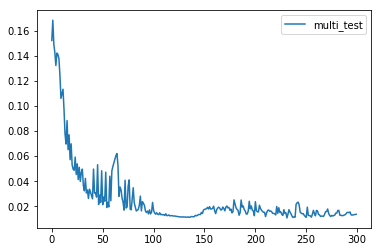

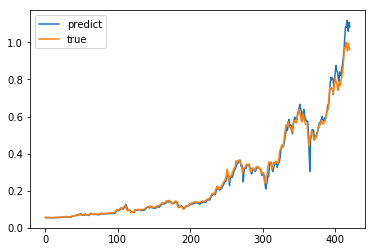

In [4]:

pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()
yhat = model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()



In [5]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 186.917


In [6]:

actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')

py.iplot([ multi_predict_chart, actual_chart])